In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.stochastic_processes.examples import DoubleWellPotentialDiffusionProcess, DoubleWellPotentialDiffusionAuxProcess
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.stochastic_processes.conds import GuidedBridgeProcess
from neuralbridge.networks.mlps import MLPSmall
from neuralbridge.models import neurb, pCN, scorematching
from neuralbridge.utils.plotting import plot_sample_path, plot_mcmc_sample_path

In [3]:
dim = 5
T = 10.0
dt = 1 / 100

params = {
    "sigma": 0.1
}

seed = 42
u = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0])
# Observe only the first three coordinates
v = jnp.array([1.0, -1.0, 1.0])
L0 = jnp.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 0.0, 0.0]])

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


In [25]:
W = WienerProcess(T, dt, shape=(dim, ))
X = DoubleWellPotentialDiffusionProcess(params, T, dim)
X_tilde = DoubleWellPotentialDiffusionAuxProcess(params, T, dim)

In [26]:
X_solver = Euler(X, W)
X_tilde_solver = Euler(X_tilde, W)

rng_key = jax.random.PRNGKey(seed)
batch_size = 32

In [27]:
X_path = X_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
X_tilde_path = X_tilde_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)

<Axes: title={'center': 'Double Well Auxiliary Process'}, xlabel='$t$', ylabel='$X_t$'>

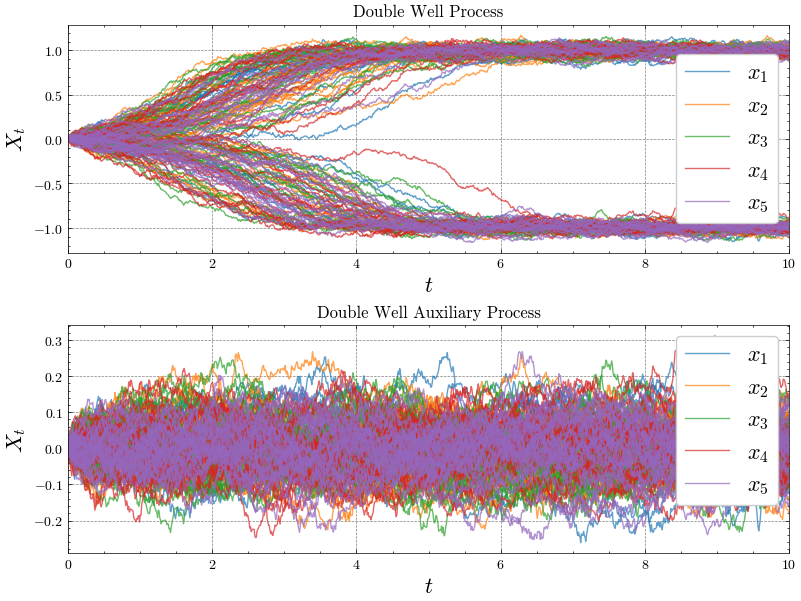

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), layout="constrained")
plot_sample_path(X_path, ax=ax[0], label=["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"], title="Double Well Process")
plot_sample_path(X_tilde_path, ax=ax[1], label=["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"], title="Double Well Auxiliary Process")

In [29]:
X_circ = GuidedBridgeProcess(
    X,
    X_tilde,
    u,
    v,
    L0,
    Sigma0=jnp.eye(3) * 1e-4,
    ts=jnp.arange(0.0, T + dt, dt),
    ode_solver_kernel="dopri5"
)

<Axes: title={'center': 'Guided Bridge Process'}, xlabel='$t$', ylabel='$X_t$'>

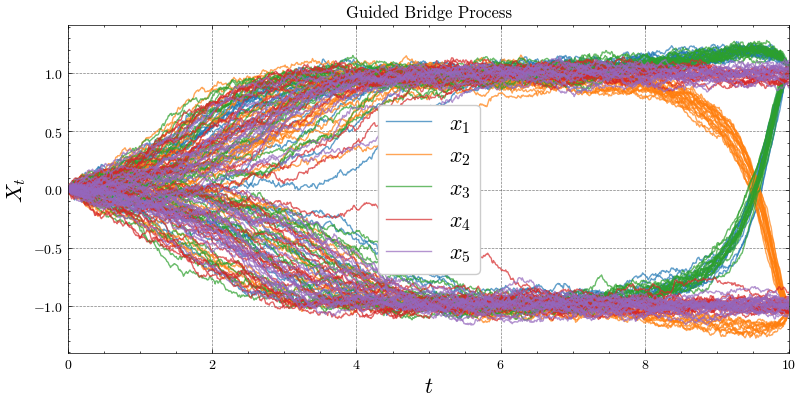

In [30]:
X_circ_solver = Euler(X_circ, W)
X_circ_path = X_circ_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
fig, ax = plt.subplots(1, 1, figsize=(8, 4), layout="constrained")
plot_sample_path(X_circ_path, ax=ax, label=["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"], title="Guided Bridge Process")

In [31]:
pCN_config = {
    "seed": seed,
    "rho": 0.9,
    "batch_size": 16,
    "n_iters": 5000
}
pCN_model = pCN.PreconditionedCrankNicolson(guided_bridge=X_circ, run_config=pCN_config)
pCN_model.initialize_path_solver(W)
pCN_result = pCN_model.run_pCN(log_every=100)

  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:root:Batch average acceptance rate: 2.62%


Text(0.5, 1.0, 'MCMC Log-likelihood')

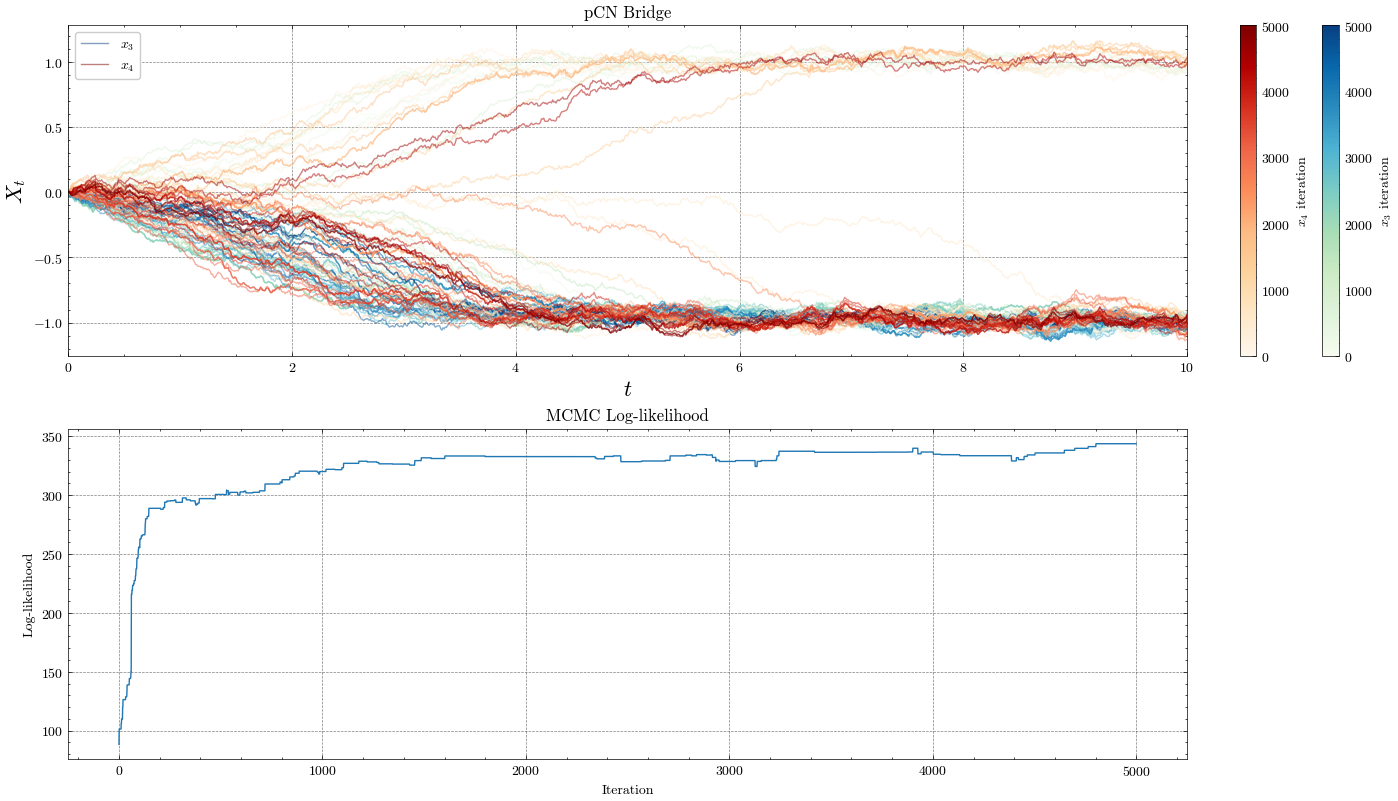

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(14, 8), layout="constrained")
plot_mcmc_sample_path(pCN_result, sample_index=0, plot_dims=(3, 4), ax=ax[0], label=["$x_3$", "$x_4$"], title="pCN Bridge", alpha=0.5, n_iters=5000)

ax[1].plot(pCN_result[-1].log_lls[:, 0])
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Log-likelihood")
ax[1].set_title("MCMC Log-likelihood")

<Axes: xlabel='$t$', ylabel='$X_t$'>

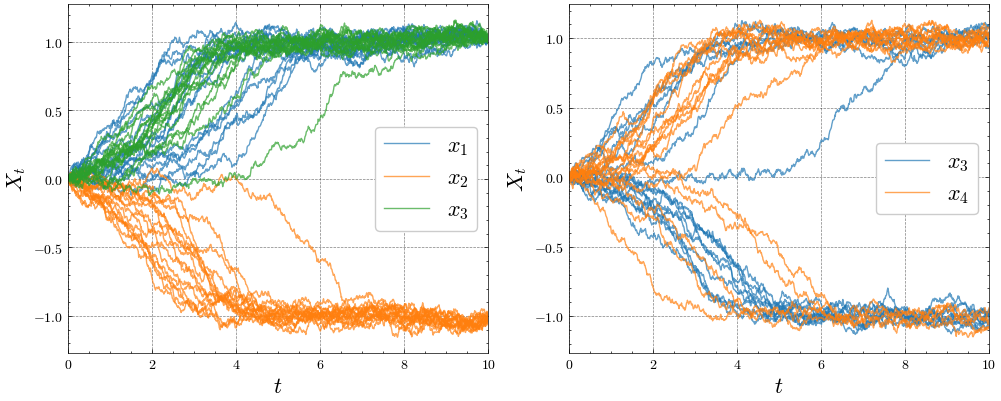

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")
plot_sample_path(pCN_result[-1].path, plot_dims=(0, 1, 2), ax=ax[0], label=["$x_1$", "$x_2$", "$x_3$"])
plot_sample_path(pCN_result[-1].path, plot_dims=(3, 4), ax=ax[1], label=["$x_3$", "$x_4$"])

In [43]:
neural_net = MLPSmall(
    out_dim=dim,
    hidden_dims=(32, 32, 32, 32),
    activation="tanh",
)

In [44]:
train_config = {
    "save_name": "double_well_model_10T",
    "seed": seed,
    "learning_rate": 1e-3,
    "batch_size": 16,
    "n_iters": 500,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 500
}

In [45]:
neural_bridge = neurb.NeuralBridge(X_circ, neural_net, train_config)

In [46]:
W = WienerProcess(T, dt, shape=(dim, ))
neural_bridge.initialize_path_solver(W)
losses = neural_bridge.train(u=u, v=jnp.array([1.0, -1.0, 1.0, jnp.nan, jnp.nan]), mode="train")

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 1 average loss: -109.08962
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/double_well_model_10T/epoch_1


Epoch 2:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 2 average loss: -214.34393
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/double_well_model_10T/epoch_2


Epoch 3:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 3 average loss: -246.33505
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/double_well_model_10T/epoch_3


Epoch 4:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 4 average loss: -257.21298
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/double_well_model_10T/epoch_4


Epoch 5:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 5 average loss: -247.33435
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/double_well_model_10T/epoch_5


Epoch 6:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 6 average loss: -254.22922
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/double_well_model_10T/epoch_6


Epoch 7:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 7 average loss: -266.55154
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/double_well_model_10T/epoch_7


Epoch 8:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 8 average loss: -272.54160
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/double_well_model_10T/epoch_8


Epoch 9:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 9 average loss: -275.08963
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/double_well_model_10T/epoch_9


Epoch 10:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 10 average loss: -276.45428
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/double_well_model_10T/epoch_10


In [47]:
X_diamond_path = neural_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

<Axes: xlabel='$t$', ylabel='$X_t$'>

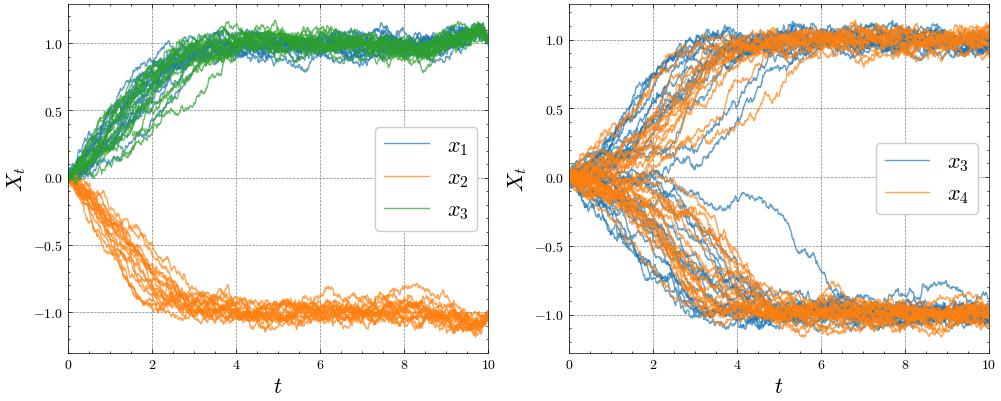

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")
plot_sample_path(X_diamond_path, ax=ax[0], plot_dims=(0, 1, 2), label=["$x_1$", "$x_2$", "$x_3$"])
plot_sample_path(X_circ_path, ax=ax[1], plot_dims=(3, 4), label=["$x_3$", "$x_4$"])